In [6]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [9]:
w, h = 304,304
border = 5 

In [10]:
ids = next(os.walk("/content/800_dataset_with_semantic_segmentation/train_images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  61


# **Data Reading and Train test split**

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
import glob
train = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_images/*"))
train_mask = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_segmentation/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 61
Total Mask Image : 61


In [13]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [14]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

In [16]:
print(X.shape, y.shape)

(61, 304, 304, 3) (61, 304, 304, 1)


In [17]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(54, 304, 304, 3) (54, 304, 304, 1) (7, 304, 304, 3) (7, 304, 304, 1)


14

# **Visualization the image and It masks**

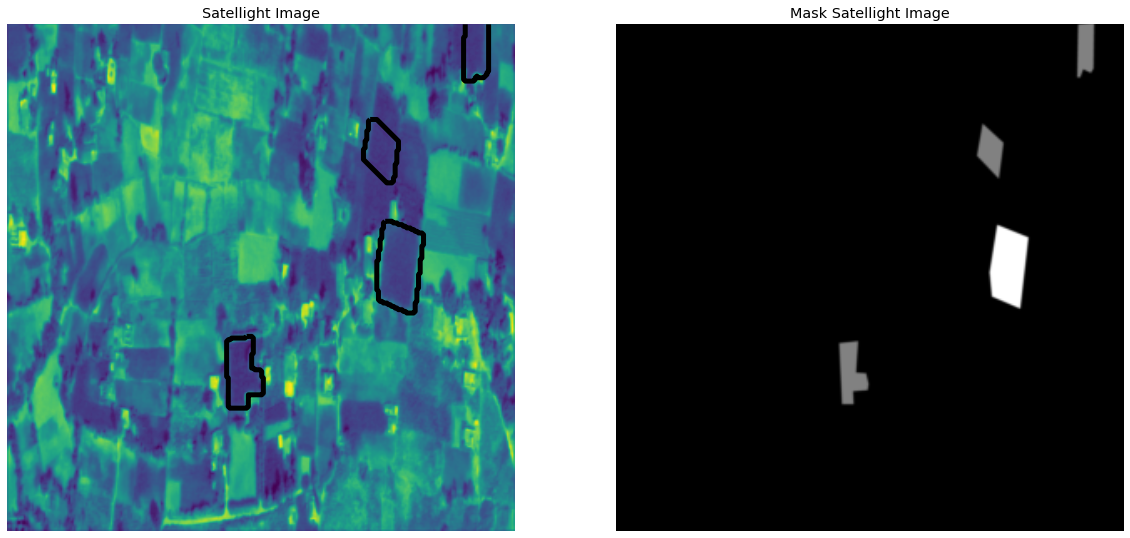

In [18]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [33]:
#@title Resnet Block
# def bn_act(x, act=True):
#     x = BatchNormalization()(x)
#     if act == True:
#         x = Activation("relu")(x)
#     return x

# def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     conv = bn_act(x)
#     conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
#     return conv

# def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
#     conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
#     shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
    
#     output = Add()([conv, shortcut])
#     return output

# def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
#     res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
#     shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
    
#     output = Add()([shortcut, res])
#     return output

# def upsample_concat_block(x, xskip):
#     u = UpSampling2D((2, 2))(x)
#     c = Concatenate()([u, xskip])
#     return c

In [ ]:
#@title ResUnet
# def ResUNet(image_size):
#     f = [16, 32, 64, 128, 256]
#     inputs = Input((image_size, image_size, 3))
    
#     ## Encoder
#     e0 = inputs
#     e1 = stem(e0, f[0])
#     e2 = residual_block(e1, f[1], strides=2)
#     e3 = residual_block(e2, f[2], strides=2)
#     e4 = residual_block(e3, f[3], strides=2)
#     e5 = residual_block(e4, f[4], strides=2)
    
#     ## Bridge
#     b0 = conv_block(e5, f[4], strides=1)
#     b1 = conv_block(b0, f[4], strides=1)
    
#     ## Decoder
#     u1 = upsample_concat_block(b1, e4)
#     d1 = residual_block(u1, f[4])
    
#     u2 = upsample_concat_block(d1, e3)
#     d2 = residual_block(u2, f[3])
    
#     u3 = upsample_concat_block(d2, e2)
#     d3 = residual_block(u3, f[2])
    
#     u4 = upsample_concat_block(d3, e1)
#     d4 = residual_block(u4, f[1])
    
#     outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
#     model = Model(inputs, outputs)
#     return model

In [34]:
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    else:
        x= Activation("relu")(x)
    return x


def ResUnet(image_size):
    inputs = Input(shape=(image_size, image_size, 3))
    filters = 16
 
    # Encoder       
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(inputs)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    shortcut = Conv2D(filters*1, kernel_size=(1,1), padding='same', strides=(1,1))(inputs)
    shortcut = batch_Norm_Activation(shortcut)
    output1 = add([conv, shortcut])
    
    res1 = batch_Norm_Activation(output1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (2,2))(res1)
    res1 = batch_Norm_Activation(res1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (1,1))(res1)
    shortcut1 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(2,2))(output1)
    shortcut1 = batch_Norm_Activation(shortcut1)
    output2 = add([shortcut1, res1])
    
    res2 = batch_Norm_Activation(output2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (2,2))(res2)
    res2 = batch_Norm_Activation(res2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (1,1))(res2)
    shortcut2 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(2,2))(output2)
    shortcut2 = batch_Norm_Activation(shortcut2)
    output3 = add([shortcut2, res2])
    
    res3 = batch_Norm_Activation(output3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (2,2))(res3)
    res3 = batch_Norm_Activation(res3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (1,1))(res3)
    shortcut3 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(2,2))(output3)
    shortcut3 = batch_Norm_Activation(shortcut3)
    output4 = add([shortcut3, res3])
    
    res4 = batch_Norm_Activation(output4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (2,2))(res4)
    res4 = batch_Norm_Activation(res4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(res4)
    shortcut4 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(2,2))(output4)
    shortcut4 = batch_Norm_Activation(shortcut4)
    output5 = add([shortcut4, res4])
    
    #bridge
    conv = batch_Norm_Activation(output5)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    
    #decoder
   
    uconv1 = UpSampling2D((2,2))(conv)
    uconv1 = concatenate([uconv1, output4])
    
    uconv11 = batch_Norm_Activation(uconv1)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    uconv11 = batch_Norm_Activation(uconv11)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    shortcut5 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(1,1))(uconv1)
    shortcut5 = batch_Norm_Activation(shortcut5)
    output6 = add([uconv11,shortcut5])
   
    uconv2 = UpSampling2D((2,2))(output6)
    uconv2 = concatenate([uconv2, output3])
    
    uconv22 = batch_Norm_Activation(uconv2)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    uconv22 = batch_Norm_Activation(uconv22)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    shortcut6 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(1,1))(uconv2)
    shortcut6 = batch_Norm_Activation(shortcut6)
    output7 = add([uconv22,shortcut6])
    
    uconv3 = UpSampling2D((2,2))(output7)
    uconv3 = concatenate([uconv3, output2])
   
    uconv33 = batch_Norm_Activation(uconv3)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    uconv33 = batch_Norm_Activation(uconv33)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    shortcut7 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(1,1))(uconv3)
    shortcut7 = batch_Norm_Activation(shortcut7)
    output8 = add([uconv33,shortcut7])
    
    uconv4 = UpSampling2D((2,2))(output8)
    uconv4 = concatenate([uconv4, output1])
    
    uconv44 = batch_Norm_Activation(uconv4)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    uconv44 = batch_Norm_Activation(uconv44)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    shortcut8 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(1,1))(uconv4)
    shortcut8 = batch_Norm_Activation(shortcut8)
    output9 = add([uconv44,shortcut8])
    
    output_layer = Conv2D(1, (3, 3), padding="same", activation="sigmoid")(output9)
    model = Model(inputs, output_layer)
  
    return model


In [47]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 3), name='img')
model = ResUnet(image_size = 304)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [48]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304, 304, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 304, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 304, 304, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 304, 304, 16) 64          input_1[0][0]                    
_______________________________________________________________________________________

In [49]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ResUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [50]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9651 - auc: 0.5443 - sensitivity_at_specificity: 0.5613 - specificity_at_sensitivity: 0.5240
Epoch 00001: val_loss improved from inf to 0.02246, saving model to model-ResUnet.h5
9/9 [==============================] - 9s 1s/step - loss: 0.1597 - accuracy: 0.9651 - auc: 0.5443 - sensitivity_at_specificity: 0.5613 - specificity_at_sensitivity: 0.5240 - val_loss: 0.0225 - val_accuracy: 0.9784 - val_auc: 0.7153 - val_sensitivity_at_specificity: 0.7088 - val_specificity_at_sensitivity: 0.7579
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9655 - auc: 0.6780 - sensitivity_at_specificity: 0.5936 - specificity_at_sensitivity: 0.7527
Epoch 00002: val_loss improved from 0.02246 to 0.01975, saving model to model-ResUnet.h5
9/9 [==============================] - 8s 865ms/step - loss: 0.0322 - accuracy: 0.9655 - auc: 0.6780 - sensitivity_at_specificity: 0.5936 - specificity_at

In [51]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
4,0.026176,0.965463,0.813187,0.785618,0.907596,0.016940,0.978397,0.796308,0.725080,0.908357,0.001
3,0.027785,0.965463,0.773894,0.730552,0.872939,0.017590,0.978397,0.721108,0.544830,0.900031,0.001
2,0.029254,0.965463,0.766669,0.789181,0.821757,0.017988,0.978397,0.755472,0.658533,0.852868,0.001
1,0.032249,0.965463,0.677982,0.593574,0.752722,0.019751,0.978397,0.780843,0.793059,0.764304,0.001
0,0.159651,0.965128,0.544282,0.561292,0.524046,0.022462,0.978397,0.715340,0.708766,0.757889,0.001


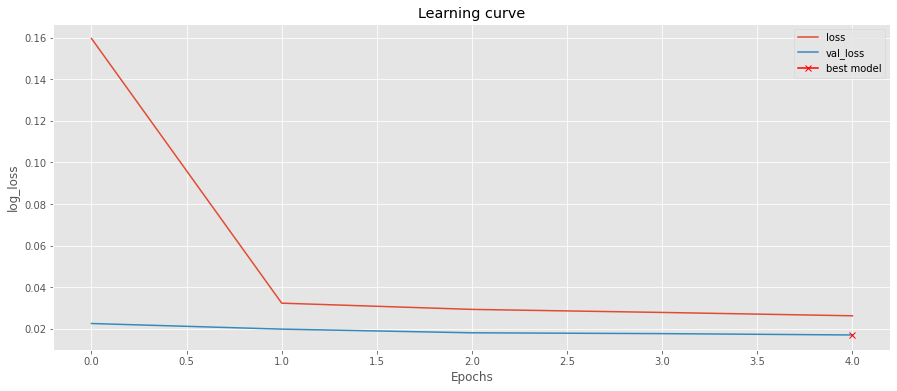

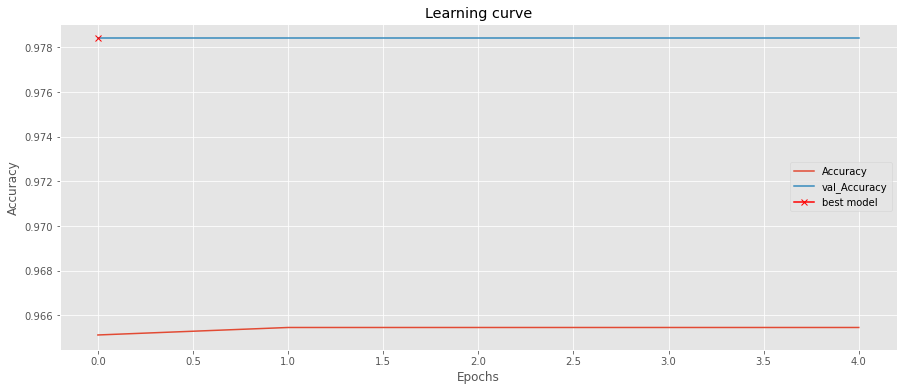

In [52]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [54]:
model.load_weights('model-ResUnet.h5')

In [55]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9784 - auc: 0.7963 - sensitivity_at_specificity: 0.7251 - specificity_at_sensitivity: 0.9084


[0.016939770430326462,
 0.9783973693847656,
 0.7963081002235413,
 0.7250804901123047,
 0.9083573818206787]

In [56]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 252ms/step


In [57]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [70]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

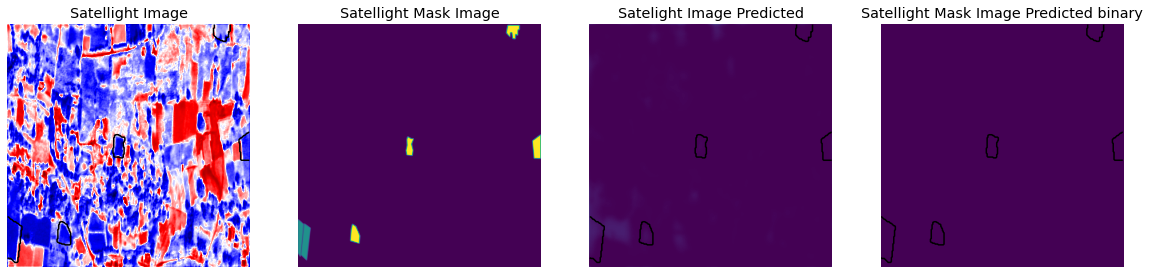

In [71]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

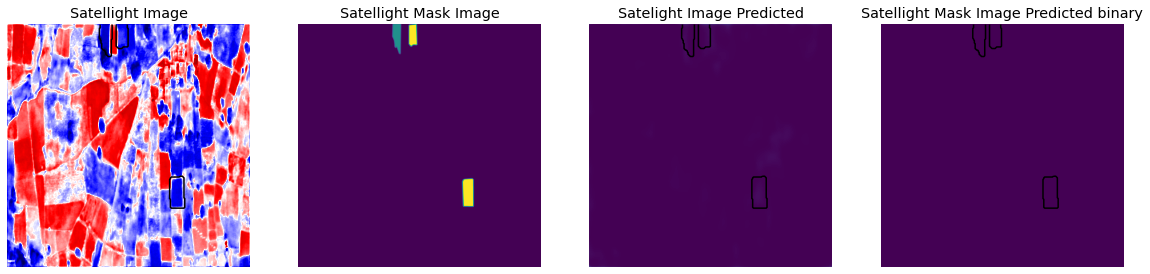

In [72]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

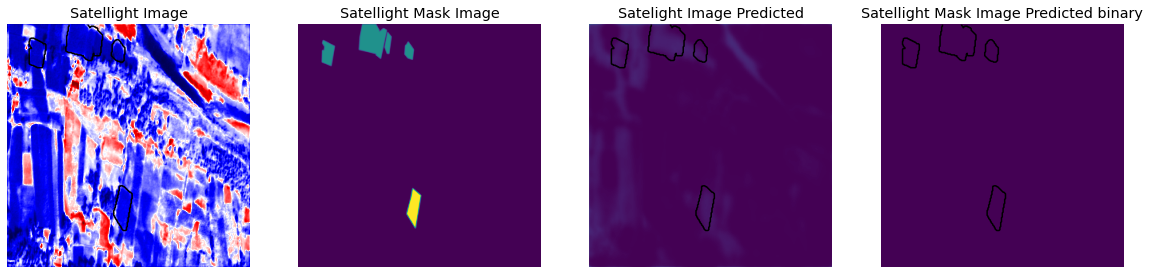

In [73]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

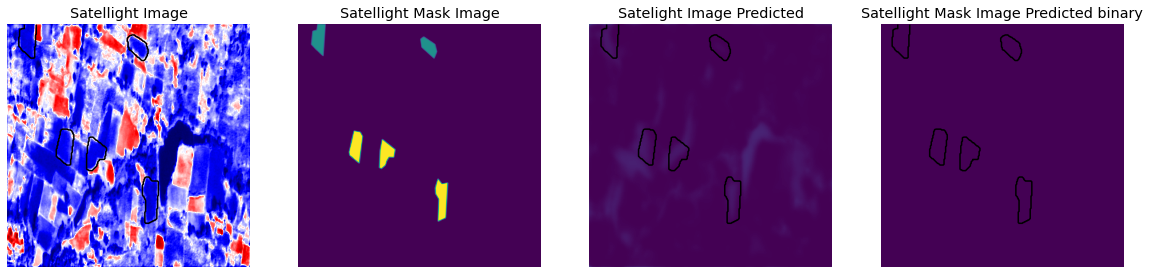

In [74]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

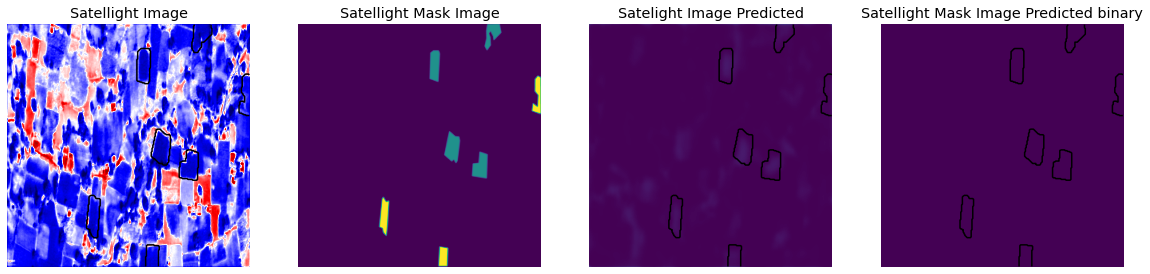

In [75]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

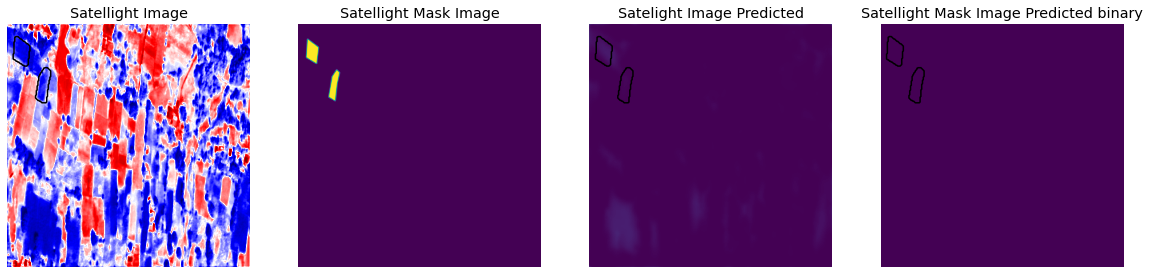

In [76]:
plot_sample(X_train, y_train, preds_train, preds_train_t)